In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_data = "../dataset/complaints.csv"

df = pd.read_csv(path_data, index_col=0)
df.reset_index(drop=True, inplace=True)

In [3]:
# df = df.sample(frac=0.1, random_state=10)

In [4]:
df.head()

,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?
0,Credit Reporting,Dear Possible Financial Inc you guyss aree rep...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Incorrect information on your report,Account information incorrect,Possible Financial Inc,MI,Yes
1,Debt Collection,"XXXX XXXX XXXX ( debt collector ), sent my boy...",Debt collection,2024-07-27,I do not know,Threatened to contact someone or share informa...,Talked to a third-party about your debt,BlueChip Financial,TX,Yes
2,Credit Reporting,I been receiving alerts my information was fou...,Credit reporting or other personal consumer re...,2024-07-23,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,FC HoldCo LLC,SC,Yes
3,Credit Reporting,Subject : Dispute of Inaccurate Information on...,Credit reporting or other personal consumer re...,2024-07-27,Credit reporting,Improper use of your report,Reporting company used your report improperly,CORELOGIC INC,GA,Yes
4,Loans,They allowed me to use the account for about a...,"Payday loan, title loan, personal loan, or adv...",2024-07-26,Payday loan,Received a loan you didn't apply for,NaN,MoneyLion Inc.,PA,Yes


In [70]:
# pd.set_option("display.max_colwidth", None)
pd.reset_option("display.max_colwidth")


In [71]:
df[["narrative", "product_5"]][df.product_5 == "Loans"].head(8)

,narrative,product_5
4,They allowed me to use the account for about a...,Loans
7,I had an installment loan under my name that w...,Loans
9,XXXX Morgage company sent a payment to XXXX XX...,Loans
21,I have disputed this information on my XXXX cr...,Loans
34,I am submitting this complaint against USAA Sa...,Loans
53,"To Whom it May Concern, Thousands of students ...",Loans
72,I am writing to file an urgent formal complain...,Loans
86,Filed for modification and a year later Shell ...,Loans


In [7]:
df.shape

(2023066, 10)

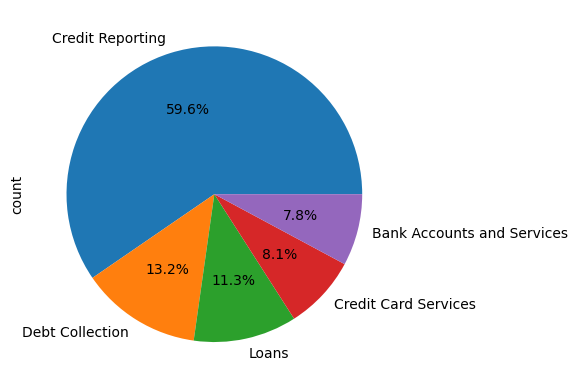

In [8]:
df.product_5.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [9]:
# category_mapping = {
#     'Credit Reporting': 0,
#     'Debt Collection': 1,
#     'Loans': 2,
#     'Credit Card Services': 3,
#     'Bank Accounts and Services': 4
# }

# df['product_5'] = df['product_5'].map(category_mapping)

In [10]:
from sklearn.utils import resample

# df_m1 = df[df.product_5 != "Credit Reporting"]

df_creditreporting = df[df.product_5 == "Credit Reporting"]
df_debtcollection = df[df.product_5 == "Debt Collection"]
df_minorityclass = df[df.product_5 != "Credit Reporting"]

df_creditreporting_balanced = resample(
    df_creditreporting,
    replace=False,
    n_samples=len(df_debtcollection),
    random_state=1
)

df_vproportional = pd.concat([df_creditreporting_balanced, df_minorityclass])

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_vproportional["label"] = le.fit_transform(df_vproportional["product_5"])

In [ ]:
#TODO: ojo, estaba definiendo de forma manual la clasificación del labelencoder pero
# esta la hace la propia herramienta, esto estaba causando errores en la predicción
# para obtener las clases y su labelencoder hago un for en enumerate(le.classes_)

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_vproportional, test_size=0.2, stratify=df_vproportional['product_5'])
train_df, dev_df = train_test_split(train_df, test_size=0.25, stratify=train_df['product_5'])

In [ ]:
#TODO: estoy tomando el target viejo product_5 y no el nuevo label para el split!!!

In [13]:
train_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

In [14]:
test_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

In [15]:
dev_df.product_5.value_counts(normalize=True).sort_index().mul(100).round(1).astype(str)+'%'

product_5
Bank Accounts and Services    14.6%
Credit Card Services          15.1%
Credit Reporting              24.6%
Debt Collection               24.6%
Loans                         21.1%
Name: proportion, dtype: object

## Modelo con Pytorch

In [16]:
import torch

print(torch.__version__)

2.1.0


In [17]:
if torch.backends.mps.is_available():
    print("MPS available")
else:
    print("MPS ERROR!!")

MPS available


In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegocardona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

In [20]:
# from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer

# le = LabelEncoder()
# # df_vproportional["label"] = le.fit_transform(df_vproportional["product_5"])
# train_df["label"] = le.fit_transform(train_df["product_5"])
# test_df["label"] = le.fit_transform(test_df["product_5"])
# dev_df["label"] = le.fit_transform(dev_df["product_5"])

base_tokenizer = get_tokenizer("basic_english")

def tokenizador(text):
    return [token for token in base_tokenizer(text) if token not in stop_words]

/Users/diegocardona/repositorios/NLP_nequi_test_diegocardona/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
train_df.head()

,product_5,narrative,Product,Date received,Sub-product,Issue,Sub-issue,Company,State,Timely response?,label
550275,Debt Collection,"My name is XXXX XXXX, I am making this complai...",Debt collection,2021-12-06,I do not know,Attempts to collect debt not owed,Debt is not yours,"Affirm Holdings, Inc",NY,Yes,3
170343,Credit Reporting,I am filing this complaint on my own behalf to...,Credit reporting or other personal consumer re...,2023-12-21,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",IN,Yes,2
32618,Credit Reporting,I am writing to file a formal complaint regard...,Credit reporting or other personal consumer re...,2024-07-02,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",SC,Yes,2
1867030,Debt Collection,"First of all, i am a young hardworking man who...",Debt collection,2021-02-07,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft,"CITIBANK, N.A.",NV,Yes,3
1747680,Debt Collection,"My credit record shows a charge due to XXXX, w...",Debt collection,2016-12-17,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,"Southwest Credit Systems, L.P.",WA,Yes,3


In [22]:
df_vproportional.label.value_counts()

label
2    266842
3    266842
4    228599
1    163710
0    158640
Name: count, dtype: int64

In [23]:
le.classes_

array(['Bank Accounts and Services', 'Credit Card Services',
       'Credit Reporting', 'Debt Collection', 'Loans'], dtype=object)

In [73]:
le.inverse_transform([2])

array(['Credit Reporting'], dtype=object)

In [25]:
def yield_tokens(data_iter):
    for texto in data_iter:
        yield tokenizador(texto)

In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")

In [27]:
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(
    yield_tokens(df_vproportional["narrative"]),
    min_freq=3,
    specials=["<unk>"],
    special_first=True,
    max_tokens=10000
    )

vocab.set_default_index(vocab["<unk>"])

In [28]:
label_pipeline = lambda x: x

texto_pipeline = lambda x: vocab(tokenizador(x))

In [29]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, df, vocab, tokenizer):
        self.labels = df["label"].values
        self.texts = df["narrative"].values
        self.vocab = vocab
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        token_ids = self.vocab(tokens)
        return torch.tensor(token_ids), torch.tensor(self.labels[idx])


In [30]:
# def collate_batch(batch):
#     label_list, text_list, offsets = [], [], [0]
#     # for label, text in batch:
#     for text, label in batch:
#         label_list.append(label)
#         text_list.append(text)
#         offsets.append(text.size(0))
#     label_list = torch.tensor(label_list, dtype=torch.int64)
#     offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
#     text_list = torch.cat(text_list)
#     return label_list, text_list, offsets

from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    text_list, label_list = [], []
    for text, label in batch:
        text_list.append(text)
        label_list.append(label)
    # pad_sequence convierte a (batch_size, max_len)
    text_padded = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return labels.to(device), text_padded.to(device)


In [31]:
# def collate_batch(batch):
#     label_list, text_list, offsets = [], [], [0]
#     for (_label, _text) in batch:
#         label_list.append(label_pipeline(_label))
#         processed_text = torch.tensor(texto_pipeline(_text), dtype=torch.int64)
#         text_list.append(processed_text)
#         offsets.append(processed_text.size(0))
#     label_list = torch.tensor(label_list, dtype=torch.int64)
#     offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
#     text_list = torch.cat(text_list)
#     return label_list.to(device), text_list.to(device), offsets.to(device)

# DataLoader
# dataset = TextDataset(df, vocab, tokenizador)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

dataset_train = TextDataset(train_df, vocab, tokenizador)
dataloader_train = DataLoader(dataset_train, batch_size=82, shuffle=True, collate_fn=collate_batch)

dataset_test = TextDataset(test_df, vocab, tokenizador)
dataloader_test = DataLoader(dataset_test, batch_size=82, shuffle=True, collate_fn=collate_batch)

dataset_dev = TextDataset(dev_df, vocab, tokenizador)
dataloader_dev = DataLoader(dataset_dev, batch_size=82, shuffle=True, collate_fn=collate_batch)

In [32]:
next(iter(dataset_train))

(tensor([  58,    2,    2,    3,  271,   69, 4706,  354,    2,  375,  138, 2113,
           22,  122,   11,  305,  269,    6,   22,  270,    1,   81, 2113, 2082,
          117,  549, 1747, 4891,    3,  126,  216,    1, 2457,   43,    2,    3,
            2,    3,    2,   52,   22,  649,   11,   19,   12,    1,   26,   21,
          163,  875,  389,  777,  177, 1306,  682,   11,   14,  166,  729,  233,
            1,  549,   45,  183, 1503,  107,  221,  328, 2113,   16,    5,    5,
          251,  228,    5,    5,    1,  214,   81, 2113,    2,    3,    2,    3,
            2,  857,   43,  349,   62,  221,  258,    3,   45,  183, 1503,    8,
          350,    7, 1007,    8,    7,   99,  714, 1060, 1248,    3, 1832,  153,
          206,   16,    5,    5, 1232,    1,   45,   74,    1,    1,  264,    0,
            1,  605,  311,   16,  396,  142,  193,  605, 4256,  539,  274,  502,
          274,   16,    1,   66, 4088,  596,  254, 3283,    3,  143,  912,  190,
           64,    8,  108,  

In [33]:
type(dataset_train)

__main__.TextDataset

In [34]:
from torch import nn
import torch.nn.functional as F

# class ModeloClasificacionTexto(nn.Module):
#   def __init__(self, vocab_size, embed_dim, num_class):
#     super(ModeloClasificacionTexto, self).__init__()

#     # capa de incrustación (embedding)
#     self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
#     # capa de normalización para los lotes (batch normalization)
#     self.bn1 = nn.BatchNorm1d(embed_dim)
#     # capa completamente conectada (fully conected), lleva las dim de la normalización
#     # y las proyecta a las dimensiones necesarias para clasificar el texto, en este caso
#     # la cantidad de clases del modelo 14
#     self.fc = nn.Linear(embed_dim, num_class)

#   # Conectamos todo en el forward
#   def forward(self, text, offsets):
#     embedded = self.embedding(text, offsets)
#     # normalizamos
#     embedded_norm = self.bn1(embedded)
#     # función de activacion relu, cuando se aplica una no linealidad como relu
#     # se les llama activated o de activación
#     embedded_activated = F.relu(embedded_norm)
#     return self.fc(embedded_activated)

class ModeloClasificacionTexto(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(ModeloClasificacionTexto, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bn1 = nn.BatchNorm1d(embed_dim)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text_batch):
        embedded = self.embedding(text_batch)  # (batch_size, seq_len, embed_dim)
        # promedio por secuencia (ignorando padding opcional)
        embedded = embedded.mean(dim=1)  # (batch_size, embed_dim)
        embedded_norm = self.bn1(embedded)
        activated = F.relu(embedded_norm)
        return self.fc(activated)


In [35]:
len(vocab)

10000

In [36]:
# con set() elimino repetidos y obtengo el numero de clases en el dataset
num_class = len(set(train_df.label))
vocab_size = len(vocab)
# vocab_size = 10000
# como el gpu es pequeño solo lo hacemos con 100
embedding_size = 100

modelo = ModeloClasificacionTexto(vocab_size=vocab_size, embed_dim=embedding_size, num_class=num_class).to(device)

In [37]:
num_class

5

In [38]:
vocab_size

10000

In [39]:
print(modelo)

ModeloClasificacionTexto(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)


In [40]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'El modelo tiene {count_parameters(modelo):,} parámetros entrenables')

El modelo tiene 1,000,705 parámetros entrenables


In [41]:
# función para entrenar el modelo
def entrena(dataloader):
  # poner el modelo en formato de entrenamiento
  modelo.train()

  # inicialización de variables para hacer seguimiento a la mejora del modelo
  # accuracy
  epoch_acc = 0
  # perdida
  epoch_loss = 0
  # cuántos ejemplos tiene el batch del dataloader
  total_count = 0

  # for idx, (label, text, offsets) in enumerate(dataloader):
  for idx, (label, text) in enumerate(dataloader):
    # reestablecer los gradientes después de cada batch
    optimizer.zero_grad()
    # predicciones
    # prediccion = modelo(text, offsets)
    prediccion = modelo(text)

    # obtención de la pérdida
    loss = criterio(prediccion, label)

    # backpropage: hacia atrás se obtiene la derivada y calcula los pesos
    loss.backward()

    # accuracy, calcula el porcentaje de correctos
    acc = (prediccion.argmax(1) == label).sum()

    # evitar que los gradientes sean demaciado rápidos
    torch.nn.utils.clip_grad_norm(modelo.parameters(), 0.1)

    # optimizar los pesos
    optimizer.step()

    torch.mps.empty_cache()

    # llevamos el conteo de la pérdida y el accuracy
    epoch_acc += acc.item()
    epoch_loss += loss.item()
    total_count += label.size(0)

    if idx % 500 == 0 and idx > 0:
      print(f'epoca {epoch} | {idx}/{len(dataloader)} batches | perdida {epoch_loss/total_count} | accuracy {epoch_acc/ total_count}')

  return epoch_acc/total_count, epoch_loss/total_count

In [42]:
# Función para evaluar el modelo
def evalua(dataloader):
  modelo.eval()
  # modelo.cuda()
  epoch_acc = 0
  epoch_loss = 0
  total_count = 0

  # cuando se va a evaluar un modelo o hacer inferencia, se debe referenciar
  # que no se haga gradiente, es decir no se entrene
  with torch.no_grad():
    # for idx, (label, text, offsets) in enumerate(dataloader):
    for idx, (label, text) in enumerate(dataloader):
      # prediccion = modelo(text, offsets)
      prediccion = modelo(text)

      loss = criterio(prediccion, label)
      acc = (prediccion.argmax(1) == label).sum()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
      total_count += label.size(0)

    return epoch_acc/total_count, epoch_loss/total_count

In [43]:
# hiperparámetros
EPOCHS = 6 # pocas porque se tiene un gpu pequeño y el modelo se ve bueno
TASA_APRENDIZAJE = 0.015 # se puede experimentar con otros, tradicionalmente 0.1, agresivo 0.3
BATCH_TAMANO = 82 # aprovechando la gpu

In [44]:
# función de pérdida
criterio = torch.nn.CrossEntropyLoss() # la convencción para llamar la función de pérdida es nombrarla criterio
# optimizer = torch.optim.SGD(modelo.parameters(), lr=TASA_APRENDIZAJE)
optimizer = torch.optim.Adam(modelo.parameters(), lr=TASA_APRENDIZAJE)

In [45]:
print(dataset_train)

In [46]:
# separación de datos entrenamiento y prueba
# from torch.utils.data.dataset import random_split
# from torchtext.data.functional import to_map_style_dataset

# # trainset y testset
# # train_iter, test_iter = DBpedia()
# # # convierte el dataset a un formato entendible por Pytorch
# # train_dataset = to_map_style_dataset(train_iter)
# # test_dataset = to_map_style_dataset(test_iter)

# num_train = int(len(dataset)*0.80)

# train_iter, test_iter = random_split(dataset, [num_train, len(dataset)-num_train])

# # entrenamiento con el 95% de datos
# num_train_ = int(len(train_iter)*0.95)

# # datos para validación, parte extra con un 5%
# split_train_, split_valid_ = random_split(train_iter, [num_train_, len(train_iter)-num_train_])

# # dataloader para ingresar al modelo
# train_dataloader = DataLoader(split_train_, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch) # shuffle es mezclar los datos de forma aleatoria
# valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch)
# test_dataloader = DataLoader(test_iter, batch_size=BATCH_TAMANO, shuffle=True, collate_fn=collate_batch)

In [47]:
len(dataloader_train)

7937

In [48]:
len(dataloader_test)

2646

In [49]:
len(dataloader_dev)

2646

In [51]:
next(iter(dataloader_train))

(tensor([1, 0, 4, 0, 0, 0, 2, 1, 2, 2, 3, 4, 0, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 0,
         0, 3, 0, 3, 0, 3, 2, 1, 3, 3, 2, 4, 3, 3, 3, 4, 0, 4, 1, 1, 4, 2, 3, 1,
         0, 2, 2, 2, 0, 0, 2, 2, 4, 3, 3, 1, 4, 3, 0, 2, 1, 2, 3, 1, 4, 3, 2, 3,
         4, 2, 0, 1, 1, 3, 3, 2, 4, 0], device='mps:0'),
 tensor([[   2,    2,    6,  ...,    0,    0,    0],
         [ 297, 5832,    1,  ...,    0,    0,    0],
         [  10,   21, 1652,  ...,    0,    0,    0],
         ...,
         [ 764,   69,    6,  ...,    0,    0,    0],
         [  21,  137,  234,  ...,    0,    0,    0],
         [ 752,  814,  174,  ...,    0,    0,    0]], device='mps:0'))

In [55]:
labels_train = [label for label, _ in dataloader_train]  # o del subset: for _, label in subset
# labels_train = torch.stack(labels_train).numpy()  # si están en tensors
labels_train = torch.cat(labels_train).cpu().numpy()

percentage_train_class = (pd.Series(labels_train).value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + '%')

percentage_train_class = percentage_train_class.rename(index=category_mapping)

print(percentage_train_class)

Credit Reporting              14.6%
Debt Collection               15.1%
Loans                         24.6%
Credit Card Services          24.6%
Bank Accounts and Services    21.1%
Name: proportion, dtype: object


In [54]:
labels_valid = [label for label, _ in dataloader_test]
# labels_valid = torch.stack(labels_valid).numpy()
labels_valid = torch.cat(labels_valid).cpu().numpy()

percentage_valid_class = (
    pd.Series(labels_valid)
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

percentage_valid_class = percentage_valid_class.rename(index=category_mapping)

print(percentage_valid_class)

Credit Reporting              14.6%
Debt Collection               15.1%
Loans                         24.6%
Credit Card Services          24.6%
Bank Accounts and Services    21.1%
Name: proportion, dtype: object


In [57]:
dataloader_val = dataloader_dev
labels_test = [label for label, _ in dataloader_val]
# labels_test = torch.stack(labels_test).numpy()
labels_test = torch.cat(labels_test).cpu().numpy()

percentage_test_class = (
    pd.Series(labels_test)
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

percentage_test_class = percentage_test_class.rename(index=category_mapping)

print(percentage_test_class)

Credit Reporting              14.6%
Debt Collection               15.1%
Loans                         24.6%
Credit Card Services          24.6%
Bank Accounts and Services    21.1%
Name: proportion, dtype: object


In [59]:
# obtención de la mejor pérdida, cuál es el que da el valor más pequeño de pérdida
major_loss_validation = float('inf') # inf: que puede tomar muchos valores diferentes

# Entrenamos
for epoch in range(1, EPOCHS+1):
  # entrenamiento
  entrenamiento_acc, entrenamiento_loss = entrena(dataloader_train)

  # validación
  validacion_acc, validacion_loss = evalua(dataloader_val)

  # guardamos el modelo con los mejores pesos
  # si la pérdida del modelo de validación es menor que el major_loss_validation
  if validacion_loss < major_loss_validation:
    best_valid_loss = validacion_loss
    torch.save(modelo.state_dict(), "mejores_pesos_guardados.pt") # modelo Pytorch termina en .pt

/var/folders/8x/shhvyxrd77s8h2qsqg9jtg5m0000gn/T/ipykernel_62282/1905407641.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(modelo.parameters(), 0.1)


epoca 1 | 500/7937 batches | perdida 0.008280781180727104 | accuracy 0.7650309137821917
epoca 1 | 1000/7937 batches | perdida 0.007521002418723436 | accuracy 0.7899417655515216
epoca 1 | 1500/7937 batches | perdida 0.007129823085147585 | accuracy 0.8018881721129003
epoca 1 | 2000/7937 batches | perdida 0.006888741556113625 | accuracy 0.8091563974110506
epoca 1 | 2500/7937 batches | perdida 0.0067046771547473035 | accuracy 0.814323051267298
epoca 1 | 3000/7937 batches | perdida 0.006572308311020332 | accuracy 0.8181988117781878
epoca 1 | 3500/7937 batches | perdida 0.0064668014772018495 | accuracy 0.8212183278645125
epoca 1 | 4000/7937 batches | perdida 0.006377883619560542 | accuracy 0.8235715461378558
epoca 1 | 4500/7937 batches | perdida 0.00630596936031346 | accuracy 0.825434456299684
epoca 1 | 5000/7937 batches | perdida 0.0062458916382169705 | accuracy 0.8269980150311401
epoca 1 | 5500/7937 batches | perdida 0.00620016050491707 | accuracy 0.828244088657938
epoca 1 | 6000/7937 batc

In [63]:
# Evaluación del modelo
test_acc, test_loss = evalua(dataloader_test)

# aquí se evalua si el modelo aprendió de forma correcta, si es bueno generalizando
print(f'Accuracy del test dataset -> {test_acc}')
print(f'Pérdida del test dataset -> {test_loss}')

Accuracy del test dataset -> 0.8147763994339109
Pérdida del test dataset -> 0.006601512495913306


In [75]:
# se usará torch.compile() para optimizar la inferencia, esto sirve para modelos pequeños
# donde no es necesario usar gpu y optimizaremos la compilacion con el mode="reduce-overhead"
category_mapping = {i: label for i, label in enumerate(le.classes_)}

def predict(text, texto_pipeline):
  with torch.no_grad():
    text_ids = texto_pipeline(text)
    text_tensor = torch.tensor([text_ids], dtype=torch.long)
    text_tensor = text_tensor.to(next(model.parameters()).device)
    # opt_mod = torch.compile(model, mode="reduce-overhead") # aumenta el uso de memoria pero optimiza la inferencia, para modelos grandes max-autotune
    # output = opt_mod(text, torch.tensor([0]))
    output = model(text_tensor)
  return output.argmax(1).item()

ejemplo_1 = "I have a problem with my credit report"

model = modelo.to("cpu") # no es necesario gpu

print(f'El emeplo 1 es de categoría {category_mapping[predict(ejemplo_1, texto_pipeline)]}')

El emeplo 1 es de categoría Credit Reporting


In [76]:
ejemplo_2 = "Can you help me with a credit card for my job?"

print(f'El emeplo 2 es de categoría {category_mapping[predict(ejemplo_2, texto_pipeline)]}')

El emeplo 2 es de categoría Credit Card Services


In [78]:
print(category_mapping[predict("Loans Loans loans", texto_pipeline)])

Loans


In [ ]:
# se usará el método state_dict() para extraer todos los parámetros (pesos) del model entrenado
# y poderlo usar en otros modelos cuando queramos.
# Nos ayuda a guardar el modelo, para seguirlo entrenando o realizar inferencia

model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()

# checkpoint o punto de guardado para futuros usos

checkpoint = {
    "model_state_dict" : model_state_dict,
    "optimizer_state_dict" : optimizer_state_dict,
    "epoch" : epoch,
    "loss" : entrenamiento_loss
}

torch.save(checkpoint, "model_checkpoint.pth") # pth o pt pueden usarse

In [ ]:
len(vocab)

10000

In [ ]:
torch.save(vocab, "vocab.pt")

In [ ]:
category_mapping = {i: label for i, label in enumerate(le.classes_)}
print(mapping)

{0: 'Bank Accounts and Services', 1: 'Credit Card Services', 2: 'Credit Reporting', 3: 'Debt Collection', 4: 'Loans'}
